### CHARGEMENT DES PACKAGES NECESSAIRES AU PROJET

In [12]:
import pandas as pd 
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt 
from PIL import Image, ImageFile, UnidentifiedImageError
import os
import pycaret 
ImageFile.LOAD_TRUNCATED_IMAGES = True 
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision 
from torchvision import datasets, models, transforms 
from tempfile import TemporaryDirectory 
from torch.utils.data import DataLoader 
from torch.utils.data import Dataset
from torchvision.models import resnet18, resnet50, VGG19_Weights
import warnings
warnings.filterwarnings("ignore")  

# from sklearn.model_selection import train_test_split
# import mlflow                                   
# import mlflow.pytorch
# Ignorer tous les avertissements
# from torchmetrics.classification import Accuracy
# from efficientnet_pytorch import EfficientNet
# import numpy as np 
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pretrainedmodels 

In [13]:
# Pour voir l'utilisation de la memoire 
import psutil
import os

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return memory_info.rss  # Mémoire utilisée en bytes 

In [14]:
# !pip install torch torchvision torchaudio 

### CHARGEMENT DES DONNEES 

In [15]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

charge_sinistre1 = pd.read_csv("/opt/spark-apps/programs/Gohou/Data/Tabes/CHARGE_SINISTRE.csv") 
disaster_declaration = pd.read_csv("/opt/spark-apps/programs/Gohou/Data/Tabes/ssysappsm_disaster_declaration.csv")
disaster_declaration2 = disaster_declaration[['id','hkeymodif','disaster_place','material_damage','circonstance_detail','file_uploaded_photo_1', 'file_uploaded_photo_2','file_uploaded_photo_3','file_uploaded_photo_4','file_uploaded_photo_5','file_uploaded_photo_6','disaster_number_milliard_added']] 
last_risq1 = pd.read_csv("/opt/spark-apps/programs/Gohou/Data/Tabes/LAST_RISQ.csv") 

print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB") 

Memory usage before: 1783.21 MB
Memory usage after: 1938.22 MB


In [16]:
# charge_sinistre1[(charge_sinistre1['COUTS_SINISTRES']!=0) & (charge_sinistre1['RECENC_ANT']!=0) & (charge_sinistre1['CODEGARA']=='TCM')]

In [17]:
charge_sinistre0 = charge_sinistre1[(charge_sinistre1['CODEGARA'].isin(['TCM','TCL','TC','TCP'])) & (~charge_sinistre1['ANNEE'].isin([2023,2024]))]

In [20]:
charge_sinistre0['CODEBRAN'].unique()

array([4])

In [21]:
len(charge_sinistre0)

39827

### CREATION D'UNE COPIE DE CHAQUE BASE 

In [26]:
charge_sinistre = charge_sinistre0.copy()
disaster_declaration1 = disaster_declaration2.copy()
last_risq = last_risq1.copy() 

In [27]:
last_risq.drop_duplicates(inplace=True)

In [28]:
print(last_risq.shape, disaster_declaration1.shape, charge_sinistre.shape)

(1803942, 28) (24406, 12) (39827, 34)


In [29]:
# la last_risq contient toutes les informations pertinentes sur le vehicule endommagé
# la table charge sinistre sera une table intermediaire qui va nous permettre de faire la jointure en disater_declalration et laast_risq.
# la table disater_declalration contient les images et la description du dommage 

In [30]:
charge_sinistre['CODEINTE'] = charge_sinistre['CODEINTE'].astype(str)
charge_sinistre['ANNEE'] = charge_sinistre['ANNEE'].astype(str)
charge_sinistre['NUMESINI'] = charge_sinistre['NUMESINI'].astype(str)
charge_sinistre['CODERISQ'] = charge_sinistre['CODERISQ'].astype(str) 
charge_sinistre['NUMEPOLI'] = charge_sinistre['NUMEPOLI'].astype(str)     

#### Creation d'une clé 'disaster_number_milliard_added' dans la table charge_sinistre pour pouvoir la joindre avec 'disaster_declaration'

In [31]:
charge_sinistre['disaster_number_milliard_added'] = charge_sinistre['CODEINTE'] + ' ' + charge_sinistre['ANNEE'] + ' ' + charge_sinistre['NUMESINI']

In [32]:
print(f"----------------------Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")


""" Importation des jeux de donnees vrepartion qui contient la variable cible et de disaster_declarration qui contient
quand à elle les differentes. Il en a 6 au total. Mais j'ai preferé aller avec les 4 premieres car les deux dernieres
contiennent parfois des iamges de qui ne sont pas des voitures (ce n'est pas tout le temps le cas) aussi pour resoudre
le un souci de memoire.
Enfin je fais une jointure entre ces deux tables avec la cle afin 'disaster_number_milliard_added' afin d'avoir une table
dans laquelle pour chaque enregistrement, on a la à la fois les 4 images du sinistre et le cout qui lui ai attribué """

print(f'disaster_declaration a {len(disaster_declaration1)} enregistrements')
print(f'charge sinistre a  {len(charge_sinistre)} enregistrements')

#jointure des deux tables 
result = pd.merge(disaster_declaration1, charge_sinistre, on ='disaster_number_milliard_added', how='inner',suffixes=('_dis', '_vrep'))
print(f'en faisant la joinutre, on se retrouve a {len(result)} enregistrements') 

print(f"---------------------Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

----------------------Memory usage before: 2268.32 MB
disaster_declaration a 24406 enregistrements
charge sinistre a  39827 enregistrements
en faisant la joinutre, on se retrouve a 8524 enregistrements
---------------------Memory usage after: 2268.32 MB


In [33]:
import gc
gc.collect() 

475

In [34]:
result['CODEINTE_NUMEPOLI_CODERISQ'] = result['CODEINTE'] + ' ' + result['NUMEPOLI'] + ' ' + result['CODERISQ'] 

In [35]:
last_risq['CODEINTE'] = last_risq['CODEINTE'].astype(str)
last_risq['NUMEPOLI'] = last_risq['NUMEPOLI'].astype(str)
last_risq['CODERISQ'] = last_risq['CODERISQ'].astype(str)
last_risq['CODEINTE_NUMEPOLI_CODERISQ'] = last_risq['CODEINTE'] + ' ' + last_risq['NUMEPOLI'] + ' ' + last_risq['CODERISQ'] 

In [36]:
result0 = pd.merge(last_risq, result, on ='CODEINTE_NUMEPOLI_CODERISQ', how='inner',suffixes=('_risq', '_sin'))
print(f'-------------------------- En faisant la joinutre, on se retrouve a {len(result0)} enregistrements ------------------------------') 

-------------------------- En faisant la joinutre, on se retrouve a 8523 enregistrements ------------------------------


In [37]:
print((min(result0['COUTS_SINISTRES'])), max(result0['COUTS_SINISTRES']))

-3848381.0 67415483.0


In [43]:
result0.head()

,CODEINTE_risq,NUMEPOLI_risq,CODERISQ_risq,AVENANT_MAX,LIBERISQ,MARQVEHI,TYPEVEHI,NUMEIMMA,DATE_MEC,CARRVEHI,CODGENAU,CODEZONE,TYPEMOTE,NUMECHAS,PUISVEHI,POIDVEHI,CYLIVEHI,VITEVEHI,NOMBPLAC,CAPRIS01,CAPRIS02,NOMPLAIN,DATEENTR,DATESORT,CREE__LE,MODI_PAR,MODI__LE,CATERISQ_risq,CODEINTE_NUMEPOLI_CODERISQ,id,hkeymodif,disaster_place,material_damage,circonstance_detail,file_uploaded_photo_1,file_uploaded_photo_2,file_uploaded_photo_3,file_uploaded_photo_4,file_uploaded_photo_5,file_uploaded_photo_6,disaster_number_milliard_added,ANNEE,DEAL_DATE,CODEINTE_sin,RAISOCIN,NUMESINI,REFEINTE,NUMEPOLI_sin,NUMEAVEN,DATEEFFE,DATEECHE,CODEASSU,NOM,CODEBRAN,LIBEBRAN,CODECATE,CATERISQ_sin,LIBECATE,CODEGARA,CODERISQ_sin,NATUSINI,LIBEGARA,DATESURV,DATEDECL,SINPAY,SINPAY_ANT,RECENC,RECENC_ANT,SOLDE_PAIEMENTS,EVAL,SAP,AREC,COUTS_SINISTRES,CODTYPSO,LIBTYPSO
0,2545,4020000323,1,3,M. TOURE SANGA IBRAHIM,MITSUBISHI,CAMIONNETTE,2026 KJ 01,2021-01-29 00:00:00.000,PS,VU,1.0,D,L4042980,8.0,1.0,NaN,NaN,5.0,26000000.0,15600000.0,NaN,2021-01-29 09:00:00.000,NaN,2021-01-29 08:01:38.000,KEVIN GNAMINI,2023-01-28 10:14:36.000,402.0,2545 4020000323 1,3328,c779e5ab19bd8b5fa2ea888cffb82b0e,CARREFOUR DE LA GENDARMERIE DE BONOUA,PARE CHOC ARRIERE DROIT,J'abordais le carrefour lorsque le véhicule qu...,1624382166-58540.jpg,1624382166-39502675.jpg,1624382166-48977437.jpg,1624382166-29909748.jpg,1624382166-36669495.jpg,1624382166-19541820.jpg,2545 2021 402693,2021,202407,2545,ASSURE PLUS,402693,NaN,4020000323,1,2021-05-06 15:45:00.000,2022-01-28 00:00:00.000,-25451201896,TOURE SANGA IBRAHIM,4,Automobile,402,402,Transport pour Propre Compte,TCM,1,Materiel,Tierce Complète,2021-06-15 12:00:00.000,2021-06-16 16:10:00.000,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,OU,Ouvert
1,2545,4020000323,1,3,M. TOURE SANGA IBRAHIM,MITSUBISHI,CAMIONNETTE,2026 KJ 01,2021-01-29 00:00:00.000,PS,VU,1.0,D,L4042980,8.0,1.0,NaN,NaN,5.0,26000000.0,15600000.0,NaN,2021-01-29 09:00:00.000,NaN,2021-01-29 08:01:38.000,KEVIN GNAMINI,2023-01-28 10:14:36.000,402.0,2545 4020000323 1,3335,70bff50012adf6a939316f88cb1c520c,ROND POINT NOUVEAU CAMP RIVIERA,PARE CHOC AVANT; FEU AVANT GAUCHE,En abordant le rond-point pour aller vers Fay...,1624448443-32020604.jpg,1624448443-87433583.jpg,1624448443-74760478.jpg,1624448443-26213914.jpg,1624448443-41652997.jpg,1624448443-27058500.jpg,2545 2021 402712,2021,202407,2545,ASSURE PLUS,402712,NaN,4020000323,1,2021-05-06 15:45:00.000,2022-01-28 00:00:00.000,-25451201896,TOURE SANGA IBRAHIM,4,Automobile,402,402,Transport pour Propre Compte,TCM,1,Materiel,Tierce Complète,2021-06-18 15:30:00.000,2021-06-21 11:55:00.000,0,1427432.0,0,0.0,0,1427432.0,0.0,0.0,1427432.0,OU,Ouvert
2,4512,4010000303,1,2,Mme YESSO BADJO NELLY BETTY MICHELE,LAND ROVER,VELAR,1804 JF 01,2018-09-03 00:00:00.000,CI,VP,1.0,E,0888,11.0,NaN,NaN,NaN,5.0,80000000.0,70000000.0,NaN,2019-07-02 00:00:00.000,NaN,2019-07-02 08:37:15.000,COULIBALY TIDIANE,2020-06-30 13:34:32.000,401.0,4512 4010000303 1,910,50afc575256045c35cfc2f80f886afb3,ABIDJAN MALL BONOUMIN,"Pare choc arriéré gauche,","J'ai garé devant Abidjan Mall, le temps de fai...",1607334493-80227861.jpg,1607334493-94515954.jpg,1607334493-54232143.jpg,1607334493-18227108.jpg,NaN,1607334493-27662763.jpg,4512 2020 405165,2020,202407,4512,Gbadie Freddy Anicet Hilaire,405165,NaN,4010000303,2,2020-07-02 00:00:00.000,2021-07-01 00:00:00.000,-39411100238,YESSO BADJO NELLY BETTY MICHELE,4,Automobile,401,401,Promenade et Affaires Personne Physique,TCM,1,Materiel,Tierce Complète,2020-12-03 19:00:00.000,2020-12-05 12:13:11.000,0,100222.0,0,0.0,0,0.0,0.0,0.0,100222.0,TR,Cloturé
3,4512,4010000303,1,2,Mme YESSO BADJO NELLY BETTY MICHELE,LAND ROVER,VELAR,1804 JF 01,2018-09-03 00:00:00.000,CI,VP,1.0,E,0888,11.0,NaN,NaN,NaN,5.0,80000000.0,70000000.0,NaN,2019-07-02 00:00:00.000,NaN,2019-07-02 08:37:15.000,COULIBALY TIDIANE,2020-06-30 13:34:32.000,401.0,4512 4010000303 1,911,408066ab835e97baf442f9350ca0a2c9,DANS MON GARAGE,Aile avant droit,Je rentrais ans mon garage et j'ai eu un accro...,16

### ANALYSE DE DESCRIPTIVES DES DONNEES (SUR LA VARIABLE CIBLE) 

#### BOXPLOT POUR VISUALISER LA DISTRIBUTION DE LA VARIABLE CIBLE 

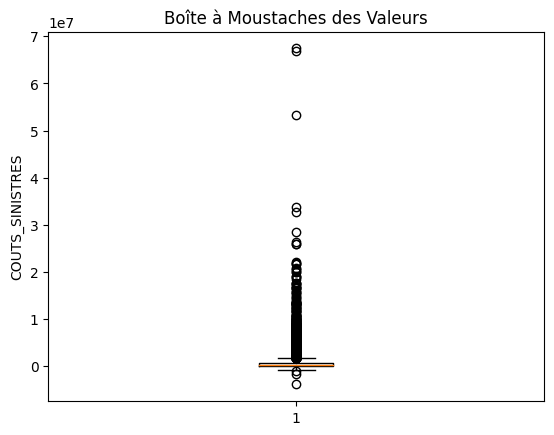

In [44]:
import matplotlib.pyplot as plt

plt.boxplot(result0['COUTS_SINISTRES']) 

# Ajout de labels et titre
plt.title('Boîte à Moustaches des Valeurs')
plt.ylabel('COUTS_SINISTRES')

# Affichage du graphique
plt.show() 

### BOXPLOT AVEC TOUTES LES VARIABLES POSITIVES 

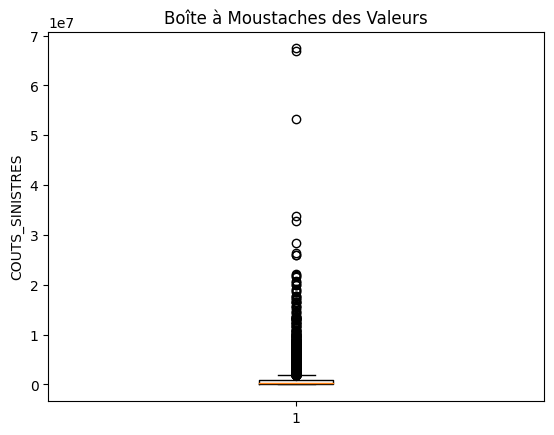

In [45]:
import matplotlib.pyplot as plt

result0 = result0[result0['COUTS_SINISTRES']>0] 
plt.boxplot(result0['COUTS_SINISTRES']) 

# Ajout de labels et titre
plt.title('Boîte à Moustaches des Valeurs')
plt.ylabel('COUTS_SINISTRES')

# Affichage du graphique
plt.show() 

### IDENTIFICATION DES VALEURS EXTREMES 

In [46]:
# df = r.reset_index(drop = True) 

# Calculer les bornes pour les valeurs extrêmes
Q1 = result0['COUTS_SINISTRES'].quantile(0.25)
Q2 = result0['COUTS_SINISTRES'].quantile(0.5)
Q3 = result0['COUTS_SINISTRES'].quantile(0.75)
IQR = Q3 - Q1     
print(Q1)
print(Q2)
print(Q3) 
print(IQR) 
# Définir les limites des moustaches
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les valeurs extrêmes
df_filtered = result0[result0['COUTS_SINISTRES'] <= upper_bound] 
print(lower_bound)
print(upper_bound)

164523.0
365965.0
852695.0
688172.0
-867735.0
1884953.0


In [47]:
# df_filtered = result0.copy()

In [48]:
import numpy as np
np.mean(result0['COUTS_SINISTRES'])

955480.4589653831

### BOXPLOT DES LA CIBLE SANS LES VALEURS EXTREMES 

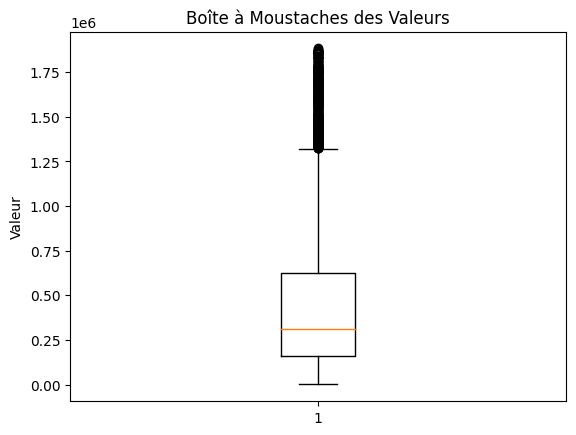

In [49]:
max(df_filtered['COUTS_SINISTRES'])
import matplotlib.pyplot as plt

plt.boxplot(df_filtered['COUTS_SINISTRES']) 

# Ajout de labels et titre
plt.title('Boîte à Moustaches des Valeurs')
plt.ylabel('Valeur')

# Affichage du graphique
plt.show()

In [50]:
len(df_filtered)
result1 = df_filtered.copy()

### TRAITEMENT DES DONNEES 

In [51]:
result1[result1['MARQVEHI']=='TOYOTA CROLLA']
result1 = result1.drop(index = 7713)

result1 = result1.reset_index()
print(result1['TYPEVEHI'].nunique())

#Gerer la variable MARQVEHI
# for i in range(len(result1['MARQVEHI'])):
#     result1.loc[i,'MARQVEHI'] = result1.loc[i,'MARQVEHI']
    
#Gerer la variable TYPEVEHI mettre une certaine coherence au niveau de la modalité VP
def normalize_typevehi(typevehi):
    typevehi = str(typevehi)
    typevehi = typevehi.upper()
    if typevehi in ['V-P', 'VP', 'V.P', 'V.P.', 'V P','V¨P',' V.P',' V.¨P']:
        return 'VP'
    return typevehi

# Appliquer la fonction à la colonne TYPEVEHI
result1['TYPEVEHI'] = result1['TYPEVEHI'].apply(normalize_typevehi)

print(result1['TYPEVEHI'].nunique()) 

def drop_nan(df):
    for col in df.columns:
        df = df[df[col] != 'nan']
    return df

result1 = drop_nan(result1)  

468
460


#### SELECTION DES COLONNES QUI NOUS INTERESSENT 

In [52]:
#Selectionner les colonnes dont on aura besoin 
result2 = result1[["CODEINTE_NUMEPOLI_CODERISQ","id", "MARQVEHI", 'TYPEMOTE', "TYPEVEHI", 'CARRVEHI', "PUISVEHI", "POIDVEHI", 'CYLIVEHI', 'VITEVEHI', 'NOMBPLAC', 'material_damage', 'disaster_place', 'circonstance_detail', 'file_uploaded_photo_1', 'file_uploaded_photo_2','file_uploaded_photo_3', 'file_uploaded_photo_4', 'file_uploaded_photo_5', 'file_uploaded_photo_6', 'CODEBRAN', 'CODEGARA', 'CODECATE', 'CAPRIS01', 'CAPRIS02', 'COUTS_SINISTRES']]

In [101]:
result2.head(

6748

#### BILAN DES VALEURS MANQUANTES

In [54]:
result2.shape

(6890, 26)

In [55]:
result2.isna().sum() / len(result2) * 100

CODEINTE_NUMEPOLI_CODERISQ      0.000000
id                              0.000000
MARQVEHI                        0.000000
TYPEMOTE                        0.000000
TYPEVEHI                        0.000000
CARRVEHI                       16.168360
PUISVEHI                        0.812772
POIDVEHI                       77.184325
CYLIVEHI                       99.622642
VITEVEHI                      100.000000
NOMBPLAC                        0.986938
material_damage                 0.000000
disaster_place                  0.014514
circonstance_detail             0.000000
file_uploaded_photo_1           0.087083
file_uploaded_photo_2           0.087083
file_uploaded_photo_3           0.087083
file_uploaded_photo_4           0.087083
file_uploaded_photo_5          23.671988
file_uploaded_photo_6          22.626996
CODEBRAN                        0.000000
CODEGARA                        0.000000
CODECATE                        0.000000
CAPRIS01                        0.159652
CAPRIS02        

#### SUPPRESSION DES COLONNES DE PLUS DE 10% DE VALEURS MANQUANTES

In [56]:
result2 = result2.drop(['CARRVEHI','POIDVEHI','VITEVEHI','CYLIVEHI','file_uploaded_photo_5','file_uploaded_photo_6'],axis=1) 
result2.isna().sum() / len(result1) * 100 

CODEINTE_NUMEPOLI_CODERISQ    0.000000
id                            0.000000
MARQVEHI                      0.000000
TYPEMOTE                      0.000000
TYPEVEHI                      0.000000
PUISVEHI                      0.812772
NOMBPLAC                      0.986938
material_damage               0.000000
disaster_place                0.014514
circonstance_detail           0.000000
file_uploaded_photo_1         0.087083
file_uploaded_photo_2         0.087083
file_uploaded_photo_3         0.087083
file_uploaded_photo_4         0.087083
CODEBRAN                      0.000000
CODEGARA                      0.000000
CODECATE                      0.000000
CAPRIS01                      0.159652
CAPRIS02                      0.159652
COUTS_SINISTRES               0.000000
dtype: float64

### GESTION DES IMPUTATIONS DES VALEURS MANQUANTES

#### MATRICE DE CORRELATION

Matrice de Corrélation ---------------------------------------------------------------------------------------------- :


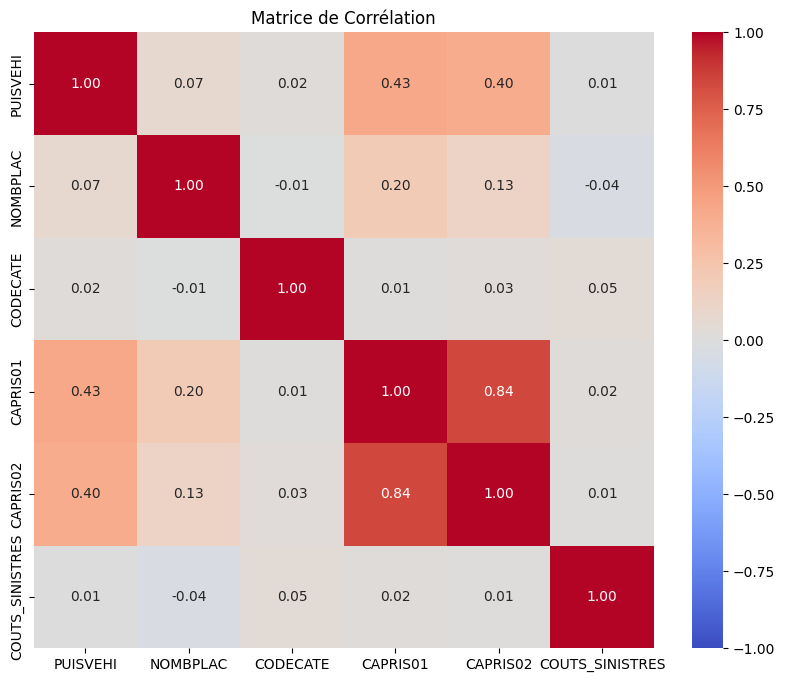

In [59]:
meric_df = result2.select_dtypes(include=['float64', 'int64'])
meric_df = meric_df.drop(columns =['CODEBRAN', 'id'], axis=1) 
correlation_matrix = meric_df.corr() 
import seaborn as sns
print("Matrice de Corrélation ---------------------------------------------------------------------------------------------- :")
#print(correlation_matrix)
# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show() 

In [60]:
""" On aurait voulu imputer les deux colonnes l'une par l'autre vu leur forte correlation, mais on fait le constat selon lequel
Les deux colonnes sont à la fois nulles en memes temps """ 
print(len(result2[result2['CAPRIS01'].isna() & result2['CAPRIS01'].notna()]))
print(len(result2[result2['CAPRIS01'].notna() & result2['CAPRIS01'].isna()])) 

0
0


In [61]:
""" Apres avoir fait des boxplot pour chaque variable, on voit que les numeriques seront toutes imputées par la mediane, du fait de l'asymetrie de nos donnees """ 

" Apres avoir fait des boxplot pour chaque variable, on voit que les numeriques seront toutes imputées par la mediane, du fait de l'asymetrie de nos donnees "

#### CHOIX DES METHODE D'IMPUTATION: Mediane pour les numeriques et mode pour les catégorielles.

In [62]:
result2.isna().sum() / len(result2) * 100

CODEINTE_NUMEPOLI_CODERISQ    0.000000
id                            0.000000
MARQVEHI                      0.000000
TYPEMOTE                      0.000000
TYPEVEHI                      0.000000
PUISVEHI                      0.812772
NOMBPLAC                      0.986938
material_damage               0.000000
disaster_place                0.014514
circonstance_detail           0.000000
file_uploaded_photo_1         0.087083
file_uploaded_photo_2         0.087083
file_uploaded_photo_3         0.087083
file_uploaded_photo_4         0.087083
CODEBRAN                      0.000000
CODEGARA                      0.000000
CODECATE                      0.000000
CAPRIS01                      0.159652
CAPRIS02                      0.159652
COUTS_SINISTRES               0.000000
dtype: float64

In [63]:
# occurrences = result2['TYPEVEHI'].value_counts()
# occurrences
# # Filtrer pour obtenir les modalités avec une seule occurrence
# modalites_une_occurrence = occurrences[(occurrences <15) & (occurrences >10)].index
# modalites_une_occurrence

In [64]:
#supprimer toutes les valeurs manquantes du jeu de données 
result2.dropna(inplace = True)
len(result2)  

6748

### ------------------------ ENCODAGE DES VARIABLES CATEGORIELLES --------------------------

In [65]:
# print(len(list(result3['TYPEVEHI'].unique())), len(list(result2['TYPEVEHI'].unique())))
# print(result3['TYPEVEHI'][0], result2['TYPEVEHI'][0]) 

In [66]:
result3 = result2.copy()

marqvehi = {
    'SUZUKI': 1,'TOYOTA': 2,'MUTSUBISHI': 3,'RENAULT': 4,'HYUNDAI':5, 'NISSAN':6, 'MAZDA':7, 'CHANGAN':8,
    'KIAMOTORS':9, 'KIAMOTORS':10, 'PEUGEOT':11, 'HAVAL':12, 'CITROEN':13,'BMW':14, 'GREAT WALL':15,
    'FORD':16, 'LAND ROVER':17, 'ISUZU':18, 'HONDA':19, 'FIAT':20,'MERCEDES':21, 'KIA':22, 'TOYOTA RAV4':23,
    'VOLKSWAGEN':24, 'SUZIKI':25, 'SINOTRUK':26,'PAJERO':27, 'TOYOTA RAV 4':28, 'FOTON':29, 'LEXUS':30,
    'NISSAN KICKS':31,'DONG FENG':32,'AUDI':33, 'TOYOTA RUSH':34, 'JMC':35,'FORLAND':36, 'MADZA':37, 'SUZUKI DZIRE':38,
    'MERCEDES BENZ':39,'MAZDA CX-5':40, 'CHANGAN P201':41, 'ASHOK LEYLAND':42
}

typevehi = {
    'VP':1, 'CAMIONNETTE':2, 'ALTO':3, 'DZIRE':4, 'VITARA':5, 'L200':6, 'CAMION':7,'SWIFT':8, 'HILUX':9,
    'TUCSON':10,'KICKS':11, 'RAV4':12, 'PRADO':13, 'CORBILLARD':14, 'RUSH':15,'LAND CRUISER':16, 'CX-5':17, 
    'PAJERO':18, 'AUTOCAR-BUS':19, '3008':20, 'SANTA FE':21,'C4 CACTUS':22, 'BALENO':23, 'FORTUNER':24, 'CX5':25,
    'PAJERO SPORT':26, 'LOGAN':27,'RAV 4':28, 'CS 55':29, 'CIAZ':30, 'L 200':31, 'NP300':32, 'A3DEE':33
}

# Appliquer le mapping avec une valeur par défaut pour les modalités non présentes dans le dictionnaire
result3['MARQVEHI'] = result3['MARQVEHI'].map(marqvehi).fillna(0) 
result3['TYPEMOTE'] = result3['TYPEMOTE'].map({'D':0, 'E':1})
result3['TYPEVEHI'] = result3['TYPEVEHI'].map(typevehi).fillna(0)
result3['CODEGARA'] = result3['CODEGARA'].map({'TCM':0, 'TC':1, 'TCL':2, 'TCP':3}).fillna(0)

In [67]:
result3.dropna(inplace = True) 

In [68]:
# result3 = result2.copy()

# #Encodage des variables catégorielles 
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# def encodage(col):
#     result3[col] = label_encoder.fit_transform(result3[col])
#     return result3

# for col in ['MARQVEHI','TYPEMOTE', 'TYPEVEHI','CODEGARA']:
#     encodage(col)

In [69]:
# from sklearn.preprocessing import LabelEncoder

# # Création d'un dictionnaire pour stocker les LabelEncoders pour chaque colonne
# label_encoders = {}

# def encodage(df, columns):
#     for col in columns:
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le  # Sauvegarde du LabelEncoder pour chaque colonne
#     return df

# # Colonnes à encoder
# columns_to_encode = ['MARQVEHI', 'TYPEMOTE', 'TYPEVEHI', 'CODEGARA']

# # Application de l'encodage
# result2 = encodage(result2.copy(), columns_to_encode)

# # Création d'une copie de result2
# result3 = result2.copy()

In [70]:
### Décodage, on en aura besoin dans l'utilisation du modele final 

In [71]:
# def decodage(df, columns): 
#     for col in columns:
#         le = label_encoders[col]
#         df[col] = le.inverse_transform(df[col])
#     return df

# # Exemple de décodage
# result3_decoded = decodage(result3.copy(), columns_to_encode)

In [74]:
!pwd

/opt/spark-apps/programs/Gohou/Scripts


#### ----- FONCTION POUR LISTER TOUTES LES IMAGES (AVOIR LA LISTE DES IMAGES ET LEUR CHEMIN) -----

In [75]:
""" Cette fonction nous permet d'avoir une liste des tous les chemins des images et une autres qui contient l'adressedes images dselon qu'elles soient stockées dans la base de donnees des images mais aussi dans la table fusionnée """
dossier = "/opt/spark-apps/programs/Gohou/Data/images/photo_extracted/Photos_sinistres/photos"
import os 
def list_image_files(directory):
    files = [] #le chemins complet    
    adresse_images = [] #l'images elle meme     
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):# Modifier selon les extensions d'images      
            files.append(os.path.join(directory, filename))
            adresse_images.append(filename)
    return files, adresse_images 
chemins, images = list_image_files(dossier) 
print(len(chemins), len(images)) 

130933 130933


###  CONNAISSANCE DES ADRESSES D'IMAGES QUI EXISTENT VRAIMENT DANS LE DATASET 

In [76]:
""" Cette fonction permet d'avoir un jeu de donnees dans lequel pour chaque adresse, sont image existe effectivement dans le dossier image. Car certaines colonnes images peuvent avoir des adresses dont l'images n'existe pas de dossier dedié"""

# Couteux en temps d'execution
def trier_data_set(df, col, img):
    liste_im = [i for i in img if i in list(df[col])]
    for elt in list(df[col]):
        if elt not in liste_im:
            try:
                position = df[col].index[df[col] == elt].tolist()[0]
                df = df[df[col] != df.loc[position, col]]
            except IndexError:
                pass# Ignorer cette itération si une erreur se produit    
    return df 

result3 = trier_data_set(result3, "file_uploaded_photo_1", images)
print(len(result3))
result3 = trier_data_set(result3, "file_uploaded_photo_2", images)
print(len(result3))
result3 = trier_data_set(result3, "file_uploaded_photo_3", images)
print(len(result3))
result3 = trier_data_set(result3, "file_uploaded_photo_4", images)
print(len(result3)) 

6673
6628
6624
6618


In [77]:
result3.columns

Index(['CODEINTE_NUMEPOLI_CODERISQ', 'id', 'MARQVEHI', 'TYPEMOTE', 'TYPEVEHI',
       'PUISVEHI', 'NOMBPLAC', 'material_damage', 'disaster_place',
       'circonstance_detail', 'file_uploaded_photo_1', 'file_uploaded_photo_2',
       'file_uploaded_photo_3', 'file_uploaded_photo_4', 'CODEBRAN',
       'CODEGARA', 'CODECATE', 'CAPRIS01', 'CAPRIS02', 'COUTS_SINISTRES'],
      dtype='object')

### RENOMMER LES COLONNES CAPRIS01 ET CAPRIS02 EN VALEUR NEUVE ET VENALE 

In [78]:
r = result3[["id","CODEINTE_NUMEPOLI_CODERISQ","MARQVEHI", "file_uploaded_photo_1","file_uploaded_photo_2","file_uploaded_photo_3","file_uploaded_photo_4","COUTS_SINISTRES",'CODEBRAN',"material_damage","disaster_place","circonstance_detail", "TYPEVEHI","PUISVEHI","NOMBPLAC","CODEGARA","CODECATE",'CAPRIS01','CAPRIS02']] 
r = r.rename(columns={'CAPRIS01':'valeur_neuve','CAPRIS02':'valeur_venale'})
df = r.copy() 

In [80]:
# df.head()

### ------------------- GESTION DE LA VARIABLE CIBLE (COÛT SINISTRE) ------------------------

In [190]:
#### BOXPLOT POUR VISUALISER LA DISTRIBUTION DE LA VARIABLE CIBLE 

In [191]:
# import matplotlib.pyplot as plt

# # Création de la boîte à moustaches
# # df = df[df['couts_sinistres']<5000000]

# plt.boxplot(r['COUTS_SINISTRES']) 

# # Ajout de labels et titre
# plt.title('Boîte à Moustaches des Valeurs')
# plt.ylabel('Valeur')

# # Affichage du graphique
# plt.show() 

In [192]:
# import matplotlib.pyplot as plt

# # Création de la boîte à moustaches
# # df = df[df['couts_sinistres']<5000000]
# r = r[r['COUTS_SINISTRES']>0] 
# plt.boxplot(r['COUTS_SINISTRES']) 

# # Ajout de labels et titre
# plt.title('Boîte à Moustaches des Valeurs')
# plt.ylabel('COUTS_SINISTRES')

# # Affichage du graphique
# plt.show() 

In [193]:
### RESTRICTION DE L'ETUDE A DES COUTS DE SINSITRE PLUS REPRESENTATIVES DE NOS DONNEES 

In [194]:
# df = r.reset_index(drop = True) 
# df = df[(df['COUTS_SINISTRES'] > 0) & (df['COUTS_SINISTRES'] <= 2000000)] 

In [195]:
# len(r)

In [196]:
# df = r.reset_index(drop = True) 

# # Calculer les bornes pour les valeurs extrêmes
# Q1 = r['COUTS_SINISTRES'].quantile(0.25)
# Q3 = r['COUTS_SINISTRES'].quantile(0.75)
# IQR = Q3 - Q1
# print(Q1)
# print(Q3) 
# print(IQR) 
# # Définir les limites des moustaches
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filtrer les valeurs extrêmes
# df_filtered = r[r['COUTS_SINISTRES'] <= upper_bound] 

In [197]:
# max(df_filtered['COUTS_SINISTRES'])

In [198]:
# max(df_filtered['COUTS_SINISTRES'])

# import matplotlib.pyplot as plt

# # Création de la boîte à moustaches
# # df = df[df['couts_sinistres']<5000000]
# plt.boxplot(df_filtered['COUTS_SINISTRES']) 

# # Ajout de labels et titre
# plt.title('Boîte à Moustaches des Valeurs')
# plt.ylabel('Valeur')

# # Affichage du graphique
# plt.show()


### ----------------CRETAION DES CLASSES EN FONCTION DE LA VARIABLE CIBLE -----------

In [81]:
import numpy as np 
q1 = df["COUTS_SINISTRES"].quantile(0.3)
print(q1)
q2 = df["COUTS_SINISTRES"].quantile(0.5) 
print(q2) 
q3 = df["COUTS_SINISTRES"].quantile(0.8) 
print(q3) 

conditions = [
    (df["COUTS_SINISTRES"] < q1),
    (df["COUTS_SINISTRES"] >= q1) & (df["COUTS_SINISTRES"] < q2),
    (df["COUTS_SINISTRES"] >= q2) & (df["COUTS_SINISTRES"] < q3),
    (df["COUTS_SINISTRES"] >= q3)
]
# Étiquettes correspondantes
labels = [0, 1, 2, 3]
# Ajout d'une nouvelle colonne contenant les catégories
df["Label"] = np.select(conditions, labels) 
# df.dropna(inplace=True) 
# df = df.reset_index(drop=True)                

171979.4
309773.5
736246.4


In [82]:
df.head()

,id,CODEINTE_NUMEPOLI_CODERISQ,MARQVEHI,file_uploaded_photo_1,file_uploaded_photo_2,file_uploaded_photo_3,file_uploaded_photo_4,COUTS_SINISTRES,CODEBRAN,material_damage,disaster_place,circonstance_detail,TYPEVEHI,PUISVEHI,NOMBPLAC,CODEGARA,CODECATE,valeur_neuve,valeur_venale,Label
0,3335,2545 4020000323 1,0.0,1624448443-32020604.jpg,1624448443-87433583.jpg,1624448443-74760478.jpg,1624448443-26213914.jpg,1427432.0,4,PARE CHOC AVANT; FEU AVANT GAUCHE,ROND POINT NOUVEAU CAMP RIVIERA,En abordant le rond-point pour aller vers Fay...,2.0,8.0,5.0,0,402,26000000.0,15600000.0,3
1,910,4512 4010000303 1,17.0,1607334493-80227861.jpg,1607334493-94515954.jpg,1607334493-54232143.jpg,1607334493-18227108.jpg,100222.0,4,"Pare choc arriéré gauche,",ABIDJAN MALL BONOUMIN,"J'ai garé devant Abidjan Mall, le temps de fai...",0.0,11.0,5.0,0,401,80000000.0,70000000.0,0
2,911,4512 4010000303 1,17.0,1607335752-12266823.jpg,1607335752-65822172.jpg,1607335752-13609220.jpg,1607335752-15005390.jpg,92139.0,4,Aile avant droit,DANS MON GARAGE,Je rentrais ans mon garage et j'ai eu un accro...,0.0,11.0,5.0,0,401,80000000.0,70000000.0,0
3,1414,4512 4010000303 1,17.0,1611133119-58808296.jpg,1611133119-10797771.jpg,1611133119-75057443.jpg,1611133119-22830921.jpg,108305.0,4,Pare choc avant gauche,COCODY SAINT JEAN,Le véhicule assuré a été accrocher par un moto...,0.0,11.0,5.0,0,401,80000000.0,70000000.0,0
4,6601,2512 4120000022 1,10.0,1644490902-18239878.jpg,1644490902-69438451.jpg,1644490902-30070697.jpg,1644490902-95279149.jpg,265013.0,4,Portière avant droit Peinture,ANGRE 7E TRANCHE,Un véhicule tiers percute le véhicule de notre...,1.0,11.0,5.0,0,412,31950000.0,12000000.0,1


1883012.0


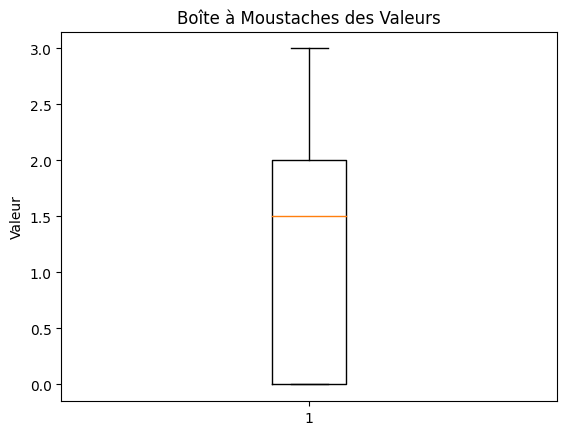

In [83]:
print(max(df['COUTS_SINISTRES']))

import matplotlib.pyplot as plt

plt.boxplot(df['Label']) 

# Ajout de labels et titre
plt.title('Boîte à Moustaches des Valeurs')
plt.ylabel('Valeur')

# Affichage du graphique
plt.show() 

#### CLASSIFICATION NON SUPERVISEE POUR DETECTER LES CLASSES NATURELLES DANS NOS DONNEES 

######  CHOIX DU BON NOMBRE DE CLASSES  

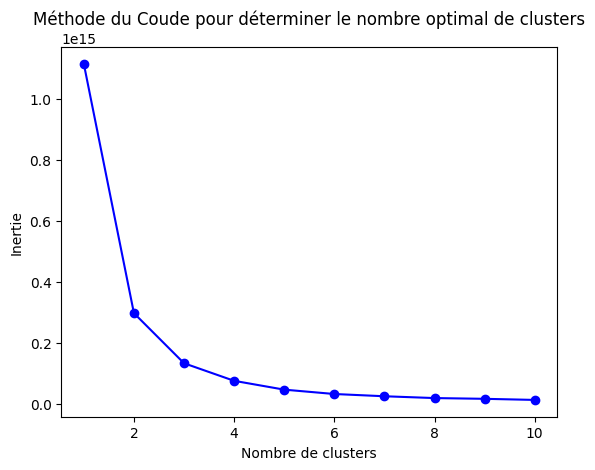

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Convertir les données en tableau numpy et les transformer en matrice 2D
X = df['COUTS_SINISTRES'].values.reshape(-1, 1)

# Appliquer K-means pour différents nombres de clusters et calculer l'inertie
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du critère du coude
plt.plot(K, inertia, 'bo-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du Coude pour déterminer le nombre optimal de clusters')
plt.show() 

###### CHOIX DE 4 CLASSES SELON LE CRITERE DE COUDE ET VISUALISATION DES CLASSES 

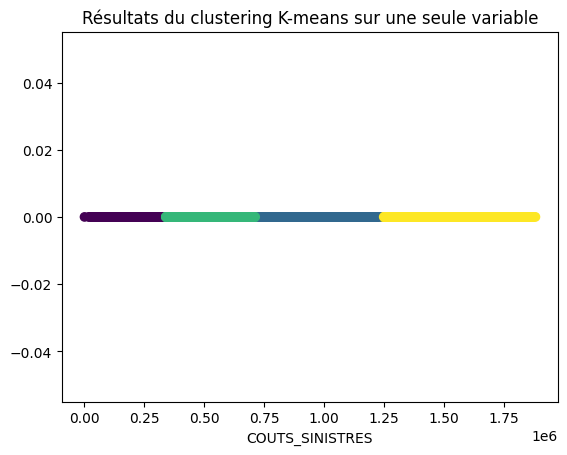

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = df['COUTS_SINISTRES'].values.reshape(-1, 1)

# Nombre optimal de clusters déterminé précédemment
optimal_clusters = 4

# Effectuer le clustering final avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Ajouter les étiquettes de clusters au DataFrame
df['cluster'] = kmeans.labels_

# Visualiser les clusters
plt.scatter(df['COUTS_SINISTRES'], np.zeros_like(df['COUTS_SINISTRES']), c=df['cluster'], cmap='viridis', marker='o')
plt.xlabel('COUTS_SINISTRES')
plt.title('Résultats du clustering K-means sur une seule variable')
plt.show() 

###### REPARTITION DES CLUSTERS PAR CLASSES 

In [86]:
print(min(df[df["cluster"]==0]["COUTS_SINISTRES"]), max(df[df["cluster"]==0]["COUTS_SINISTRES"]))
print(min(df[df["cluster"]==1]["COUTS_SINISTRES"]), max(df[df["cluster"]==1]["COUTS_SINISTRES"])) 
print(min(df[df["cluster"]==2]["COUTS_SINISTRES"]), max(df[df["cluster"]==2]["COUTS_SINISTRES"]))
print(min(df[df["cluster"]==3]["COUTS_SINISTRES"]), max(df[df["cluster"]==3]["COUTS_SINISTRES"])) 

490.0 333903.0
726006.0 1236653.0
334318.0 725651.0
1237675.0 1883012.0


In [87]:
df["cluster"] = df["cluster"].astype(str) 
conditions = {'0':0,'1':2, '2':1,'3':3} 
df["cluster"] = df["cluster"].map(conditions)

In [88]:
# df["cluster"] = df["cluster"].astype(str) 
# conditions = {'0':0,'1':2, '2':1} 
# df["cluster"] = df["cluster"].map(conditions) 

In [89]:
print(min(df[df["cluster"]==0]["COUTS_SINISTRES"]), max(df[df["cluster"]==0]["COUTS_SINISTRES"]))
print(min(df[df["cluster"]==1]["COUTS_SINISTRES"]), max(df[df["cluster"]==1]["COUTS_SINISTRES"]))
print(min(df[df["cluster"]==2]["COUTS_SINISTRES"]), max(df[df["cluster"]==2]["COUTS_SINISTRES"]))
print(min(df[df["cluster"]==3]["COUTS_SINISTRES"]), max(df[df["cluster"]==3]["COUTS_SINISTRES"]))

490.0 333903.0
334318.0 725651.0
726006.0 1236653.0
1237675.0 1883012.0


In [226]:
# df.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df_global.csv') 

In [100]:
# df.head()

In [93]:
# df.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df_global.csv') 

In [95]:
data = pd.read_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df_global.csv')

In [96]:
data = data.drop('Unnamed: 0', axis =1)
df = data.copy() 

In [98]:
# df.head()

In [99]:
# df.head()

In [234]:
df["cluster"].value_counts() 

cluster
0    3459
1    1809
2     866
3     484
Name: count, dtype: int64

In [235]:
df['COUTS_SINISTRES'].describe() 

count    6.618000e+03
mean     4.612242e+05
std      4.105201e+05
min      4.900000e+02
25%      1.600000e+05
50%      3.097735e+05
75%      6.245062e+05
max      1.883012e+06
Name: COUTS_SINISTRES, dtype: float64

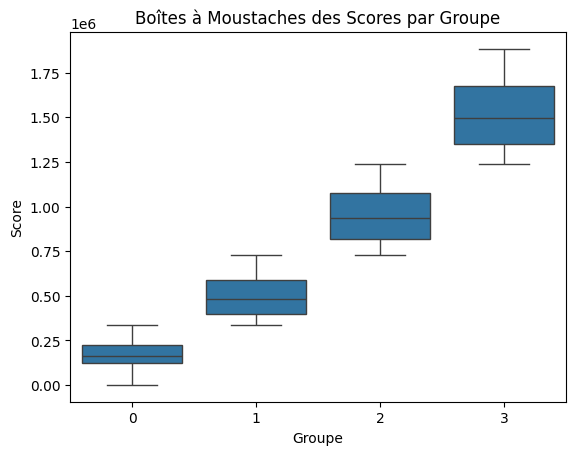

In [236]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Création des boîtes à moustaches pour chaque groupe
sns.boxplot(x='cluster', y= df['COUTS_SINISTRES'], data= df)

# Ajout de labels et titre
plt.title('Boîtes à Moustaches des Scores par Groupe')
plt.xlabel('Groupe')
plt.ylabel('Score')

# Affichage du graphique 
plt.show()

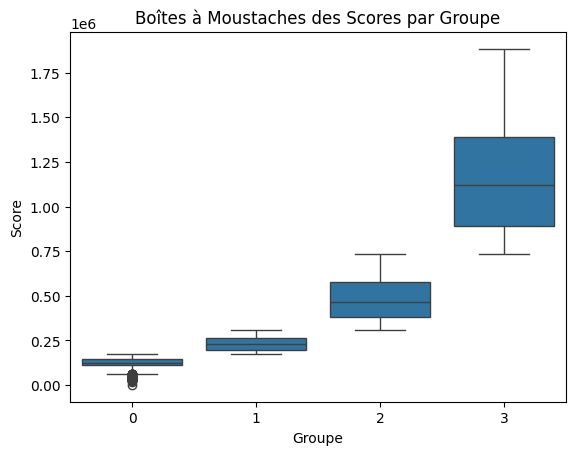

In [237]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Création des boîtes à moustaches pour chaque groupe
sns.boxplot(x='Label', y=df['COUTS_SINISTRES'], data=df)

# Ajout de labels et titre
plt.title('Boîtes à Moustaches des Scores par Groupe')
plt.xlabel('Groupe')
plt.ylabel('Score')

# Affichage du graphique 
plt.show()

Text(0.5, 1.0, 'Répartition des Données selon les Labels')

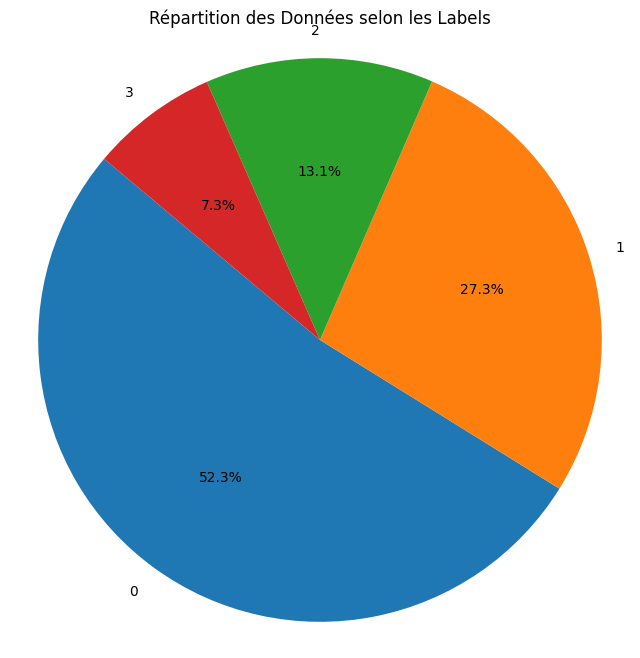

In [238]:
label_counts = df['cluster'].value_counts()

# Créer le diagramme circulaire 
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)

# Assurer que le diagramme est un cercle
plt.axis('equal')

# Ajouter un titre
plt.title("Répartition des Données selon les Labels")

In [239]:
print(max(df["COUTS_SINISTRES"]), min(df["COUTS_SINISTRES"]))

1883012.0 490.0


In [240]:
from sklearn.model_selection import train_test_split
df2 = df.copy() 
df1, df_val = train_test_split(df2, test_size=0.96, random_state=42, stratify= df2['cluster'])
print(len(df1)) 

264


In [241]:
def split_dataframe_data(dataset, batch_size):
    dfs = []
    for i in range(0, len(dataset), batch_size):
        df = dataset.iloc[i:i + batch_size]
        dfs.append(df) 
    return dfs
dff = split_dataframe_data(df2, 100) 

### --------------------- REMPLACER LES ADRESSES PAR LES VRAIES IMAGES ------------------- 

In [242]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

import gc
import os
from PIL import Image

def split_dataframe_into_batches(dataset, batch_size):
    for i in range(0, len(dataset), batch_size):
        yield dataset.iloc[i:i + batch_size]

def process_image(x):  
    full_path = os.path.join(dossier, x) if isinstance(x, str) else x
    if full_path in chemins and full_path not in treated_paths:
        treated_paths.add(full_path) 
        try:
            if os.path.exists(full_path):
                with Image.open(full_path) as img:  # Use 'with' to ensure the image is closed after processing
                    return img.copy()  # Return a copy to keep the image after the 'with' block
            else:
                print(f"Image not found: {full_path}")
                return np.nan
        except Exception as e:
            print(f"Error loading image {full_path}: {e}")
            return np.nan
    else:
        return np.nan 
treated_paths = set() 

# batch_df2 = pd.DataFrame() 
# for batch_df in split_dataframe_into_batches(dff[45], 10):  # Adjust batch size if necessary
#     for i in range(1,5):
#         batch_df.loc[:,f'file_uploaded_photo_{i}'] = batch_df.loc[:,f'file_uploaded_photo_{i}'].apply(process_image)
#     batch_df2 = pd.concat([batch_df2, batch_df], ignore_index=True)
#     del batch_df 
#     gc.collect()  

# print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

Memory usage before: 2833.06 MB


### ---------------------------------  PARALELLISATION  ------------------------------

In [244]:
# print(len(batch_df2))  
# batch_df2.dropna(inplace=True)
# batch_df2 = batch_df2.reset_index(drop=True)
# print(len(batch_df2))

##### EXTRACTION DES CARACTERISTIQUES DANS LES IMAGES AVEC UN RESEAU DE NEURONE CONVOLUTIONNEL 

In [245]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn

resnet_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
resnet_model.fc = nn.Identity()  # Remove the final classification layer

image_transforms = transforms.Compose([ 
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])  

def image_to_features(col): 
    image = image_transforms(col).unsqueeze(0)
    features = resnet_model(image) 
    return features.squeeze(0)

# batch_df2['feature_images'] = batch_df2['file_uploaded_photo_1'].apply(image_to_features)

# batch_df3 = pd.DataFrame() 
# for batch_df in split_dataframe_into_batches(batch_df2, 10):  # Adjust batch size if necessary
#     for i in range(1,5):
#         batch_df.loc[:, f'feature_images_{i}'] = batch_df.loc[:,f'file_uploaded_photo_{i}'].apply(image_to_features) 
#     batch_df3 = pd.concat([batch_df3, batch_df], ignore_index=True)
#     del batch_df 
#     gc.collect()  
# print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

Memory usage before: 2833.06 MB


### EXTRACTION DES CARACTERISTIQUES DANS LES IMAGES AVEC UN TRANSFORMER 

In [246]:
# !pip install transformers

In [247]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")
import logging
from transformers import logging as transformers_logging
from transformers import BertTokenizer, BertModel
import torch

# Configurer le niveau de logging pour ignorer les avertissements
transformers_logging.set_verbosity_error() 
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device) 
# bert_model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")

def text_to_features(text): 
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze(0)  # squeeze(0) pour revoir la dimension

# batch_df3['description'] = batch_df3['material_damage'].apply(text_to_features) 

# batch_df4 = pd.DataFrame() 
# for batch_df in split_dataframe_into_batches(batch_df3, 10):  # Adjust batch size if necessary
#     batch_df.loc[:,'material_damage'] = batch_df.loc[:,'material_damage'].apply(text_to_features)
#     batch_df.loc[:,'circonstance_detail'] = batch_df.loc[:,'circonstance_detail'].apply(text_to_features)
#     batch_df.loc[:,'disaster_place'] = batch_df.loc[:,'disaster_place'].apply(text_to_features)
#     batch_df4 = pd.concat([batch_df4, batch_df], ignore_index=True)
#     del batch_df 
#     gc.collect()  
# print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

Memory usage before: 2837.74 MB


In [248]:
# def case(df1, batch_size, path): 
#     batch_df4 = pd.DataFrame() 
#     for batch_df in split_dataframe_into_batches(df1, batch_size):  # Adjust batch size if necessary
#         for i in range(1,5):
#             batch_df.loc[:,f'file_uploaded_photo_{i}'] = batch_df.loc[:,f'file_uploaded_photo_{i}'].apply(process_image)
#             batch_df.loc[:, f'feature_images_{i}'] = batch_df.loc[:,f'file_uploaded_photo_{i}'].apply(image_to_features)
#             batch_df.loc[:,'material_damage'] = batch_df.loc[:,'material_damage'].apply(text_to_features)
#             batch_df.loc[:,'circonstance_detail'] = batch_df.loc[:,'circonstance_detail'].apply(text_to_features)
#             batch_df.loc[:,'disaster_place'] = batch_df.loc[:,'disaster_place'].apply(text_to_features)
#         batch_df4 = pd.concat([batch_df4, batch_df], ignore_index=True)
#         del batch_df
#         gc.collect()

#         # Supposons que vous avez déjà extrait vos caractéristiques d'images et de textes
#         X_images_np_1 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_1']])  # Convertir en tableau NumPy
#         X_images_np_2 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_2']])
#         X_images_np_3 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_3']])
#         X_images_np_4 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_4']])
#         X_texts_np_1 = np.array([feat.detach().numpy() for feat in batch_df4['material_damage']])  # Convertir en tableau NumPy
#         X_texts_np_2 = np.array([feat.detach().numpy() for feat in batch_df4['circonstance_detail']]) 
#         X_texts_np_3 = np.array([feat.detach().numpy() for feat in batch_df4['disaster_place']]) 
#         X_marq_np = batch_df4['MARQVEHI'].to_numpy()
#         X_typevehi_np = batch_df4['TYPEVEHI'].to_numpy()
#         X_puivehi_np = batch_df4['PUISVEHI'].to_numpy()
#         X_nbreplace_np = batch_df4['NOMBPLAC'].to_numpy()
#         X_codegara_np = batch_df4['CODEGARA'].to_numpy()
#         X_codecat_np = batch_df4['CODECATE'].to_numpy()
#         X_codebran_np = batch_df4['CODEBRAN'].to_numpy()
#         X_capri1_np = batch_df4['valeur_neuve'].to_numpy()
#         X_capri2_np = batch_df4['valeur_venale'].to_numpy() 


#         # Redimensionner les tableaux si nécessaire
#         X_images_np_1 = X_images_np_1.reshape(len(X_images_np_1), -1) # Redimensionner en 2D si c'est actuellement 1D
#         X_images_np_2 = X_images_np_2.reshape(len(X_images_np_2), -1)
#         X_images_np_3 = X_images_np_3.reshape(len(X_images_np_3), -1)
#         X_images_np_4 = X_images_np_4.reshape(len(X_images_np_4), -1)
#         X_texts_np_1 = X_texts_np_1.reshape(len(X_texts_np_1), -1) # Redimensionner en 2D si c'est actuellement 1D
#         X_texts_np_2 = X_texts_np_2.reshape(len(X_texts_np_2), -1)
#         X_texts_np_3 = X_texts_np_3.reshape(len(X_texts_np_3), -1) 
#         X_marq_np = X_marq_np.reshape(len(X_marq_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
#         X_typevehi_np = X_typevehi_np.reshape(len(X_typevehi_np), -1)
#         X_puivehi_np = X_puivehi_np.reshape(len(X_puivehi_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
#         X_nbreplace_np = X_nbreplace_np.reshape(len(X_nbreplace_np), -1)
#         X_codegara_np = X_codegara_np.reshape(len(X_codegara_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
#         X_codecat_np = X_codecat_np.reshape(len(X_codecat_np), -1)
#         X_codebran_np = X_codebran_np.reshape(len(X_codebran_np), -1)
#         X_capri1_np = X_capri1_np.reshape(len(X_capri1_np), -1)
#         X_capri2_np = X_capri2_np.reshape(len(X_capri2_np), -1)
#         X_combined = np.concatenate((X_texts_np_1, X_texts_np_2, X_texts_np_3, X_images_np_1, X_images_np_2, X_images_np_3, X_images_np_4, X_marq_np, X_typevehi_np, X_puivehi_np, X_nbreplace_np, X_codegara_np, X_codecat_np, X_codebran_np, X_capri1_np, X_capri2_np), axis=1) #X_capri2_np,  X_texts_np_3, X_images_np_4, X_texts_np_2, ,X_images_np_3 
#         columns_names = [f'feature_{i+1}' for i in range(X_combined.shape[1])]
#         X1_combined = pd.DataFrame(X_combined, columns = columns_names)
#         # Labels ou cibles
#         y = batch_df4['cluster'].values                    
#         df3 = pd.concat([X1_combined, batch_df4['cluster']], axis =1) 
#         df3.to_csv(path)
#         print(f'------------{path} chargé avec succes -------------')

In [1]:
# import threading
# out = pd.DataFrame() 
# threads = []
# for i, df in enumerate(dff):
#     try:
#         thread = threading.Thread(target = case, args =(df, 10, f'/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df_{i}.csv')) 
#         threads.append(thread)
#         thread.start()
#     except Exception as e:
#         print(f"Error in thread processing {path}: {str(e)}")µ

In [ ]:
# for thread in threads:
#     thread.join() 
# print(out) 

###### TRANSFORMER TOUTES LES COLONNES EN TABLEAU NUMPY AFIN QU'ILS SOIENT COMPATIBLE AVEC LES CARACTERISTIQUES DES IMAGES ET DES TEXTES

In [83]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Supposons que vous avez déjà extrait vos caractéristiques d'images et de textes
X_images_np_1 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_1']])  # Convertir en tableau NumPy
X_images_np_2 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_2']])
X_images_np_3 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_3']])
X_images_np_4 = np.array([feat.detach().numpy() for feat in batch_df4['feature_images_4']])
X_texts_np_1 = np.array([feat.detach().numpy() for feat in batch_df4['material_damage']])  # Convertir en tableau NumPy
X_texts_np_2 = np.array([feat.detach().numpy() for feat in batch_df4['circonstance_detail']]) 
X_texts_np_3 = np.array([feat.detach().numpy() for feat in batch_df4['disaster_place']]) 
X_marq_np = batch_df4['MARQVEHI'].to_numpy()
X_typevehi_np = batch_df4['TYPEVEHI'].to_numpy()
X_puivehi_np = batch_df4['PUISVEHI'].to_numpy()
X_nbreplace_np = batch_df4['NOMBPLAC'].to_numpy()
X_codegara_np = batch_df4['CODEGARA'].to_numpy()
X_codecat_np = batch_df4['CODECATE'].to_numpy()
X_codebran_np = batch_df4['CODEBRAN'].to_numpy()
X_capri1_np = batch_df4['valeur_neuve'].to_numpy()
X_capri2_np = batch_df4['valeur_venale'].to_numpy() 


# Redimensionner les tableaux si nécessaire
X_images_np_1 = X_images_np_1.reshape(len(X_images_np_1), -1) # Redimensionner en 2D si c'est actuellement 1D
X_images_np_2 = X_images_np_2.reshape(len(X_images_np_2), -1)
X_images_np_3 = X_images_np_3.reshape(len(X_images_np_3), -1)
X_images_np_4 = X_images_np_4.reshape(len(X_images_np_4), -1)
X_texts_np_1 = X_texts_np_1.reshape(len(X_texts_np_1), -1) # Redimensionner en 2D si c'est actuellement 1D
X_texts_np_2 = X_texts_np_2.reshape(len(X_texts_np_2), -1)
X_texts_np_3 = X_texts_np_3.reshape(len(X_texts_np_3), -1) 
X_marq_np = X_marq_np.reshape(len(X_marq_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
X_typevehi_np = X_typevehi_np.reshape(len(X_typevehi_np), -1)
X_puivehi_np = X_puivehi_np.reshape(len(X_puivehi_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
X_nbreplace_np = X_nbreplace_np.reshape(len(X_nbreplace_np), -1)
X_codegara_np = X_codegara_np.reshape(len(X_codegara_np), -1)  # Redimensionner en 2D si c'est actuellement 1D
X_codecat_np = X_codecat_np.reshape(len(X_codecat_np), -1)
X_codebran_np = X_codebran_np.reshape(len(X_codebran_np), -1)
X_capri1_np = X_capri1_np.reshape(len(X_capri1_np), -1)
X_capri2_np = X_capri2_np.reshape(len(X_capri2_np), -1)


# Concaténer ou combiner vos caractéristiques
X_combined = np.concatenate((X_texts_np_1, X_texts_np_2, X_texts_np_3, X_images_np_1, X_images_np_2, X_images_np_3, X_images_np_4, X_marq_np, X_typevehi_np, X_puivehi_np, X_nbreplace_np, X_codegara_np, X_codecat_np, X_codebran_np, X_capri1_np, X_capri2_np), axis=1) #X_capri2_np,  X_texts_np_3, X_images_np_4, X_texts_np_2, ,X_images_np_3 

# Labels ou cibles
y = batch_df4['cluster'].values              

# # Initialisation et entraînement du modèle RandomForest
# model_rf = RandomForestClassifier(n_estimators=100, max_depth=20)
# model_rf.fit(X_combined, y)

# # Prédiction avec le modèle entraîné 
# predictions = model_rf.predict(X_combined)       

### --------- RECONSTITUTION TOUTES LES SORTIES EN UN SEUL DATAFRAME --------------- 

In [84]:
columns_names = [f'feature_{i+1}' for i in range(X_combined.shape[1])]
X1_combined = pd.DataFrame(X_combined, columns = columns_names)

In [85]:
X1_combined.shape

(100, 4360)

In [ ]:
df3 = pd.concat([X1_combined, batch_df4['cluster']], axis =1) 
df3.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df46.csv') 

In [ ]:
# n_files = 20  # Remplace ceci par le nombre exact de fichiers CSV que tu as

# # Crée une liste des chemins des fichiers CSV
# file_paths = [f'/opt/spark-apps/programs/Gohou/Data/Tabes/df{i}.csv' for i in range(1, n_files + 1)]

# # Lire les fichiers CSV et stocker les DataFrames dans une liste
# list_df = [pd.read_csv(file_path) for file_path in file_paths] 
# print(len(list_df))
# df_final = pd.concat(list_df, ignore_index=True)  
# print(len(df_final))

In [ ]:
# liste = [] 
# for classif in Best_Model:
#     kf = KFold(n_splits=10, shuffle=True, random_state=1)
#     proba = cross_val_predict(classif,X_final, Y_final, cv = kf, method='predict_proba')[:,1]
#     predictions = (proba > seuil_fixe).astype(int)
#     acc = accuracy_score(Y_final, predictions)
#     liste.append(acc)

# resultats_final = pd.DataFrame({"Modele":['logistic','elasticnet','Ridge','Lasso','Arbre','Random','Xgboost','knn','Gradient_boosting',
#                                   'adaboost_classifier', 'Bagging','SVM','LDA','QDA'],"Accuracy_seuil":liste})
# print(resultats_final)

In [ ]:
df3 = pd.concat([X1_combined, batch_df4['cluster']], axis =1) 
from sklearn.model_selection import train_test_split
df2 = df3.copy() 

### REEQUILIBRAGE DE NOS DONNEES VU QU'ELLES SONT DESEQUILIBREES 

In [ ]:
# %pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df2.drop(columns='cluster')  # Variables indépendantes
y = df2['cluster'] 

# # Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Application de SMOTE pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la distribution des classes après suréchantillonnage
print("Distribution des classes avant suréchantillonnage :", Counter(y_train))
print("Distribution des classes après suréchantillonnage :", Counter(y_train_resampled))

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# Initialisation et entraînement du modèle RandomForest 
model_rf = RandomForestClassifier(n_estimators=50, max_features = 'sqrt', min_samples_leaf=0.3) 
model_rf.fit(X_train_resampled, y_train_resampled) 

# Prédictions sur l'ensemble de test 
y_pred = model_rf.predict(X_train_resampled) 

# Évaluation du modèle
accuracy = accuracy_score(y_train_resampled, y_pred)  
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_train_resampled, y_pred, average='weighted')
print(f'f1_score: {f1:.2f}')

abs_pred_val_train = np.mean([abs(l-p) for l,p in zip(list(y_train_resampled), list(y_pred))])
pred_val_train = np.mean([p-l for l,p in zip(list(y_train_resampled), list(y_pred))]) 

print(f'Valeur absolue des diffrence en train : {abs_pred_val_train}')
print(f'difference entre predictions et labels en train : {pred_val_train}') 

print('-------------------------------Perf Random Forest en Train------------------------------------')

# Matrice de confusion
conf_matrix = confusion_matrix(y_train_resampled, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')  

# Rapport de classification (incluant precision, recall, f1-score)
class_report = classification_report(y_train_resampled, y_pred)
print(f'Classification Report:\n{class_report}')   

In [ ]:
# Prédictions sur l'ensemble de test 
y_pred = model_rf.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'f1_score: {f1:.2f}')

abs_pred_val_train = np.mean([abs(l-p) for l,p in zip(list(y_test), list(y_pred))])
pred_val_train = np.mean([p-l for l,p in zip(list(y_test), list(y_pred))]) 

print(f'Valeur absolue des diffrence en train : {abs_pred_val_train}')
print(f'difference entre predictions et labels en train : {pred_val_train}') 

print('-------------------------------Perf Random Forest en Train------------------------------------')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')  

# Rapport de classification (incluant precision, recall, f1-score)
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')   

In [ ]:
plt.figure(figsize=(8, 6))
# Normaliser la matrice de confusion en pourcentage
cm_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show() 

In [ ]:
from sklearn.model_selection import cross_val_score,KFold,cross_val_predict,train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

### Ridge 

In [ ]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

param_grid = {                          
    "C": [0.00001,0.001,1,10,100],   
    "solver": ["sag","lbfgs","liblinear"] ,
    'class_weight': ['balanced'],
} 

ridge = LogisticRegression(penalty="l2")
ridge_cv = GridSearchCV(ridge, param_grid, cv=kf,scoring='f1') 
ridge_cv.fit(X_train_resampled, y_train_resampled)

print(ridge_cv.best_params_)  
print(ridge_cv.best_score_)

print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

# Initialisation et entraînement du modèle RandomForest 
model_rf =  GradientBoostingClassifier(n_estimators=50, max_depth=3, max_features= 0.3, learning_rate=0.1, subsample=0.7) #subsample=0.5
model_rf.fit(X_train_resampled, y_train_resampled)

# Prédictions sur l'ensemble de test 
y_pred = model_rf.predict(X_train_resampled) 

# Évaluation du modèle
accuracy = accuracy_score(y_train_resampled, y_pred)  
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_train_resampled, y_pred, average='weighted')
print(f'f1_score: {f1:.2f}')

abs_pred_val_train = np.mean([abs(l-p) for l,p in zip(list(y_train_resampled), list(y_pred))])
pred_val_train = np.mean([p-l for l,p in zip(list(y_train_resampled), list(y_pred))]) 

print(f'Valeur absolue des diffrence en train : {abs_pred_val_train}')
print(f'difference entre predictions et labels en train : {pred_val_train}') 

print('-------------------------------  Perf Random Forest en Train  ------------------------------------')

# Matrice de confusion
conf_matrix = confusion_matrix(y_train_resampled, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')  

# Rapport de classification (incluant precision, recall, f1-score)
class_report = classification_report(y_train_resampled, y_pred)
print(f'Classification Report:\n{class_report}')   

In [ ]:
# Prédictions sur l'ensemble de test 
y_pred = model_rf.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred)  
print(f'Accuracy: {accuracy:.2f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'f1_score: {f1:.2f}')

abs_pred_val_train = np.mean([abs(l-p) for l,p in zip(list(y_test), list(y_pred))])
pred_val_train = np.mean([p-l for l,p in zip(list(y_test), list(y_pred))]) 

print(f'Valeur absolue des diffrence en train : {abs_pred_val_train}')
print(f'difference entre predictions et labels en train : {pred_val_train}') 

print('-------------------------------Perf Random Forest en Train------------------------------------')

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')  

# Rapport de classification (incluant precision, recall, f1-score)
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')   

In [ ]:
plt.figure(figsize=(8, 6))
# Normaliser la matrice de confusion en pourcentage
cm_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show() 

### Lasso

In [ ]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

param_grid = {                          
    "C": [0.0001,0.001,1,10,100],   
    "solver": ["sag","lbfgs","liblinear"] ,
    'class_weight': ['balanced'],
} 

lasso = LogisticRegression(penalty="l1")
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf,scoring="f1") 
lasso_cv.fit(X_train_resampled, y_train_resampled)

print(lasso_cv.best_params_)  
print(lasso_cv.best_score_)  

print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

### Logistics

In [ ]:
# print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

# param_grid = {                          
#     "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],   
#     "max_iter" :[10000,11000],
#     'solver' : ['liblinear']
# }

# Logistic = LogisticRegression()

# Logistic_cv = GridSearchCV(Logistic, param_grid, cv=kf,scoring="f1") 
# Logistic_cv.fit(X_train_resampled, y_train_resampled)

# print(Logistic_cv.best_params_)  
# print(Logistic_cv.best_score_) 

# print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

### Random Forest

In [ ]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

a = int(np.sqrt(len(X.columns)))
param_grid = {                          
    "n_estimators": [50, 70, 100],   
    "min_samples_leaf": [0.05, 0.07, 0.01],
    "max_features": [a, a+5, a+10] 
}

Arbre = RandomForestClassifier()

Arbre_cv = GridSearchCV(Arbre, param_grid, cv=kf,scoring="f1")
Arbre_cv.fit(X_train_resampled, y_train_resampled)

print(Arbre_cv.best_params_)
print(Arbre_cv.best_score_) 

print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB") 

In [ ]:
print(a) 

#### Xgboost

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'colsample_bytree': [0.7,0.8,0.9],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5], 
    "objective":["multi:softmax"],
}

xgb_classifier = xgb.XGBClassifier() 

xgb_classifier_cv = GridSearchCV(xgb_classifier,param_grid,cv=kf,scoring="f1")
xgb_classifier_cv.fit(X_train_resampled, y_train_resampled)

print(xgb_classifier_cv.best_params_)
print(xgb_classifier_cv.best_score_) 

### Gradient Boosting 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, AdaBoostClassifier
param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 4, 5],   #arbre pas trop profond 
    "max_features": ['sqrt', 'log2'],  
}

gb_classifier = GradientBoostingClassifier()

gb_classifier_cv = GridSearchCV(gb_classifier, param_grid, cv=kf,scoring="f1")
gb_classifier_cv.fit(X_train_resampled, y_train_resampled)


print(gb_classifier_cv.best_params_)
print(gb_classifier_cv.best_score_) 

### Adaboost

In [11]:
param_grid = {
    "n_estimators": [100,150,200],
    "learning_rate": [0.01, 0.1 ,0.2], 
    "algorithm":["SAMME","SAMME.R"],
}

adaboost_classifier = AdaBoostClassifier()

adaboost_cv = GridSearchCV(adaboost_classifier, param_grid, cv=kf,scoring="f1")
adaboost_cv.fit(X_train_resampled, y_train_resampled)

print(adaboost_cv.best_params_)
print(adaboost_cv.best_score_)

NameError: name 'AdaBoostClassifier' is not defined

### Bagging 

In [ ]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier,BaggingRegressor,VotingClassifier

a = int(np.sqrt(len(X.columns)))
param_grid = {
    "n_estimators": [50,100,150],
    "max_features": [a-5,a,a+5],
    "max_samples" : [0.6,0.65,0.7],
    "bootstrap_features": [True, False],
}

base_classifier = DecisionTreeClassifier()
bagging_classifier = BaggingClassifier(base_classifier)
bagging_classifier_cv = GridSearchCV(bagging_classifier, param_grid, cv=kf,scoring="f1")
bagging_classifier_cv.fit(X_train_resampled, y_train_resampled)

print(bagging_classifier_cv.best_params_)
print(bagging_classifier_cv.best_score_) 

### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Définir un modèle SVM
svm = SVC()

# Définir les hyperparamètres à tester
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],  # Pour le noyau polynomiale
}

# Configurer la recherche en grille
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1', cv=kf)
grid_search.fit(X_train_resampled, y_train_resampled)

print(bagging_classifier_cv.best_params_)
print(bagging_classifier_cv.best_score_) 

In [ ]:
classifiers = [
    ('Logistic_Logistique', LogisticRegression(C=0.000001, max_iter=10000)),
    ('Classification_Ridge', LogisticRegression(penalty="l2", C=10, solver='liblinear', max_iter=10000)),
    ('Classification_Lasso', LogisticRegression(penalty="l1", C=1, max_iter=9000, solver='liblinear')),
    ('Arbre', DecisionTreeClassifier(max_depth=1000, min_samples_leaf=23, min_samples_split=15)),
    ('Random_Forest', RandomForestClassifier(max_features=3, min_samples_leaf=1, n_estimators=700)),
    ('Xgboost', xgb.XGBClassifier(objective='multi:softmax', colsample_bytree=0.6, max_depth=12, n_estimators=100, num_class=2)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient_boosting', GradientBoostingClassifier(n_estimators=300, max_depth=5)),
    ('adaboost_classifier', AdaBoostClassifier(n_estimators=150, learning_rate=0.2, algorithm='SAMME')),
    ('Bagging', BaggingClassifier(base_classifier, max_features=4, n_estimators=250))
]

for name, classifier in classifiers:
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    y_pred = cross_val_predict(classifier, X, Y, cv=kf)
    acc = accuracy_score(Y, y_pred)
    print(f"{name} Accuracy: {np.mean(acc)}")

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
BaggingClassifier(base_classifier, max_features=30, n_estimators=200)
y_pred = cross_val_predict(base_classifier, X_train_resampled, y_train_resampled, cv=kf)
f1 = f1_score(y_train_resampled, y_pred, average='macro')
print(f1) 

In [ ]:
# plt.figure(figsize=(10, 7))
# sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
#             yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
# plt.xlabel('Prédictions')
# plt.ylabel('Réelles')
# plt.title('Matrice de Confusion')
# plt.show()


# conf_matrix = confusion_matrix(y_train, y_pred) 

# # Visualiser la matrice de confusion avec seaborn
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
#             yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
# plt.xlabel('Prédictions')
# plt.ylabel('Réelles')
# plt.title('Matrice de Confusion')
# plt.show() 

In [ ]:
### Test sur de nouvelles donnees




In [ ]:
df_final = pd.concat[

In [ ]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier,BaggingRegressor,VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict, train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
a = int(np.sqrt(len(X_final.columns)))

dico =  {'logistic':LogisticRegression(),
         'elastic':LogisticRegression(penalty="elasticnet", solver="saga"),
         'ridge':LogisticRegression(penalty="l2"),
         'lasso':LogisticRegression(penalty="l1"),
         'Arbre':DecisionTreeClassifier(),
         'Random':RandomForestClassifier(),
         'xgb':xgb.XGBClassifier(),
         'knn':KNeighborsClassifier(),
         'Gradient_boosting':GradientBoostingClassifier(),
         'adaboost_classifier':AdaBoostClassifier(),
         'Bagging':BaggingClassifier(DecisionTreeClassifier()),
         'SVM':SVC(),
         'LDA':LinearDiscriminantAnalysis(),
         'QDA':LinearDiscriminantAnalysis(),
         'lightgbm': LGBMClassifier(),  # Ajout de LightGBM
         'catboost': CatBoostClassifier(verbose=0)  # Ajout de CatBoost
        } 

param = [{"C": [0.0000001,0.000001,0.00001],"max_iter" :[10000,11000]},
         {"C": [0.00001,0.001,1,10,100],"l1_ratio": [0.1, 0.5, 0.7],"max_iter" :[9000,10000,11000]},
         {"C": [0.00001, 0.001, 1, 10, 100],"solver": ["sag", "lbfgs", "liblinear"],"max_iter": [10000, 11000]},
         {"C": [0.00001,0.001,1,10,100],"solver": ["liblinear"],"max_iter" :[9000,10000,11000]},
         {"max_depth": [500,1000],"min_samples_split": [10,5,15],"min_samples_leaf": [5,7,8]},
         {"n_estimators": [900,1000,1200],"min_samples_leaf": [1],"max_features": [a-1,a,a+1]},
         {'colsample_bytree': [0.5, 0.6, 0.7],"n_estimators": [20, 25, 30, 50, 100],"max_depth": [10, 12, 15],"objective":["multi:softmax"],"num_class":[2]},
         {'n_neighbors':[3, 5, 7]},{"n_estimators": [100, 200, 300],"max_depth": [3, 5, 10]},
         {"n_estimators": [70,80,100,200],"learning_rate": [0.001,0.1,0.2],"algorithm":["SAMME","SAMME.R"]},
         {"n_estimators": [60, 80, 200, 300],"max_features": [a-5, a, a+1]},
         {"kernel": ['linear','rbf','poly'], "C": [0.1, 1, 3, 5]},
         {"solver": ['svd','lsqr'],"shrinkage": [0.1, 0.15, 0.2, 0.9]},
         {'tol':[1e-4,0.001,0.1,0.9],"solver": ['svd','lsqr']},
         {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [10, 15, 20]},
         {"iterations": [100, 200], "depth": [6, 8, 10], "learning_rate": [0.01, 0.1, 0.2]}
        ]

meilleurs_parametres = []
Accuracy = []
# Accuracy_avec_seuil_fixe = [] 
Best_Model = []
temps = []
i=0

for nom, model in dico.items():
    model = dico[nom]
    model_cv = GridSearchCV(model, param_grid=param[i], cv = kf, scoring="f1_score")
    temps_debut = time.time()
    model_cv.fit(X_final,Y_final)
    temps_fin = time.time()
    temps_execution = temps_fin - temps_debut
    temps.append(temps_execution) 
    #meilleurs_parametres.append(model_cv.best_params_)
    Accuracy.append(model_cv.best_score_)
    best_model = model_cv.best_estimator_
    Best_Model.append(best_model) 
    # proba = cross_val_predict(best_model,X_final, Y_final, cv = kf, method='predict_proba')[:,1]
    # predictions = (proba > seuil_fixe).astype(int)
    # accuracy = accuracy_score(Y_final, predictions)
    # Accuracy_avec_seuil_fixe.append(accuracy)
    i = i+1 

resultats = pd.DataFrame({"modele":['logistic','elasticnet','Ridge','Lasso','Arbre','Random','Xgboost','knn','Gradient_boosting',
                                  'adaboost_classifier', 'Bagging','SVM','LDA','QDA','lightgbm','catboost'],
                                   "Accuracy":Accuracy,
                                   #"Accuracy_avec_seuil":Accuracy_avec_seuil_fixe,
                                   'Temps_Execution':temps})

print(resultats)

In [ ]:
liste = [] 
for classif in Best_Model:
    kf = KFold(n_splits=10, shuffle=True, random_state=42) 
    predictions = cross_val_predict(classif, X_final, Y_final, cv = kf) #, method='predict_proba')[:,1]
    # predictions = (proba > seuil_fixe).astype(int)
    f1 = f1_score(Y_final, predictions) 
    liste.append(f1) 

resultats_final = pd.DataFrame({"Modele":['logistic','elasticnet','Ridge','Lasso','Arbre','Random','Xgboost','knn','Gradient_boosting',
                                          'adaboost_classifier', 'Bagging','SVM','LDA','QDA','lightgbm','catboost'],
                                "F1_Score":liste})
print(resultats_final)
meilleur_modele = resultats_final.loc[resultats_final["F1_Score"].idxmax()] 
print(meilleur_modele) 

In [ ]:
import pycaret
pycaret.__version__

In [ ]:
print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")
from  pycaret.classification import *
s = setup(X_train, target = y_train, session_id = 123,
          fix_imbalance=True,
          remove_outliers = True,
          log_experiment = True,
          experiment_name = 'Memoire',
         )
print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

In [ ]:
# !mlflow ui --host 0.0.0.0 

In [ ]:
# print(f"Memory usage before: {get_memory_usage() / (1024 * 1024):.2f} MB")

# best = compare_models()

# print(f"Memory usage after: {get_memory_usage() / (1024 * 1024):.2f} MB")

In [ ]:
best_model = compare_models(exclude =['catboost', 'lightgbm', 'gbc','lr','dummy','xgboost'],
                            sort='F1',
                            budget_time=0.5,
                            cross_validation=False,
                            parallel = FugueBackend(spark),
                            n_select=3)   

In [ ]:
print(best_model)

In [ ]:
# pour voir les hyperparamètres du modele
evaluate_model(best_model) 

In [ ]:
tuned_best_model = tune_model(best) 

In [ ]:
custom_grids = {
    'qda': {  # Logistic Regression
        'priors': [0.33, 0.33, 0.33, 0.33],
        'reg_params': [0.1, 0.4, 0.7],
        'tol': [0.1, 0.4, 0.7] 
    },
    'rf': {  # Random Forest
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [100, 200,300],
        'min_samples_split': [2, 4, 6]
    },
    'gbc': {  # Gradient Boosting Classifier
        'n_estimators': [100,200,400],
        'learning_rate': [0.001, 0.001, 0.2],
        'max_depth': [3, 5, 7]
    },
    'xgboost': {  # XGBoost
        'n_estimators': [300, 100, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    # Ajouter d'autres modèles et leurs grilles de paramètres ici
}

In [ ]:
# model = create_model('qda')  # Exemple avec un Random Forest

# tuned_model = tune_model(model, custom_grid={
#     'priors':  [[0.25, 0.25, 0.25, 0.25], [0.3,0.3,0.2,0.2]], 
#     'reg_param': [0.1, 0.2, 0.3],
#     'tol': [0.01, 0.1, 0.2]
# })



# model = create_model('rf')  # Exemple avec un Random Forest

# tuned_model = tune_model(model, custom_grid={
#     'n_estimators': [250,300,400],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [20,25,30],
#     'min_samples_leaf':[20,25,30]
# })


model = create_model('xgboost', return_train_score = True)  # Exemple avec un Random Forest
tuned_model = tune_model(model, custom_grid={

'n_estimators': [300, 100, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
}) 

In [ ]:
tuned_model

In [ ]:
predictions = predict_model(tuned_model, data = X_train)
predictions.head()

In [ ]:
import mlflow 

In [ ]:
tuned_model

In [ ]:
# tuned_models = []

# # Appliquer la grille de paramètres personnalisée à chaque modèle
# for model_name, grid in custom_grids.items():
#     if model_name in best_model: 
#         model = get_model(model_name)
#         tuned_model = tune_model(model, custom_grid=grid)
#         tuned_models.append(tuned_model)

# # Afficher les résultats des modèles tunés
# for model in tuned_models:
#     print(model) 

In [ ]:
final_best_model = compare_models(models=tuned_models) 

In [ ]:
# tuned_best_model

In [ ]:
predictions = predict_model(tuned_model, data = X_train)
predictions.head()

In [ ]:
predictions['prediction_label'].unique()

In [ ]:
liste = [1 if l==p else 0 for l,p in zip(list(y_train),list(predictions['prediction_label']))] 
sum(liste)/len(liste) 

In [ ]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

In [ ]:
inspect.getsource(compare_models())